# Аналитика в Яндекс.Афише


**Задача:** помочь маркетологам оптимизировать маркетинговые затраты
- как люди пользуются продуктом?
- когда они начинают покупать?
- сколько денег приносит каждый клиент?  
- когда клиент окупается? 

**Данные:** (с июня 2017 по конец мая 2018 года)
- лог сервера с данными о посещениях сайта Яндекс.Афиши,  
- выгрузка всех заказов за этот период,  
- статистика рекламных расходов.

## Шаг 1. Загрузка данных и подготовка их к анализу

*Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный*

In [472]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [473]:
print(visits.info())
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [474]:
print(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [475]:
print(costs.info())
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [476]:
#приведем даты к формату datetime
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [477]:
#Уберем из датасета ошибочные заходы (случаи, когда пользователь не провел на сайте и секунды)
visits['duration'] = visits['End Ts'] - visits['Start Ts']
visits['duration']= visits['duration'].dt.seconds.div(60)
visits = visits.query('duration > 0')

## Шаг 2. Отчеты и метрики

***Продукт***  
*-- Сколько людей пользуются в день, неделю, месяц?*  
*-- Сколько сессий в день?*  
*-- Сколько длится одна сессия?*  
*-- Как часто люди возвращаются?*  
***Продажи***  
*-- Когда люди начинают покупать?*  
*-- Сколько раз покупают за период?*  
*-- Какой средний чек?*  
*-- Сколько денег приносят? (LTV)*  
***Маркетинг***  
*-- Сколько денег потратили? Всего / на каждый источник / по времени*  
*-- Сколько стоило привлечение одного покупателя из каждого источника?*  
*-- На сколько окупились расходы? (ROI)*  

*Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?*

### *Шаг 2.1.1 Сколько людей пользуются в день, неделю, месяц?*

In [478]:
#Добавим столбцы с днями, неделями и месяцами
visits['week'] = visits['Start Ts'].astype('datetime64[W]')
visits['month'] = visits['Start Ts'].astype('datetime64[M]')
visits['date'] = visits['Start Ts'].dt.date

#Рассчитаем среднее количество уникальных пользователей
print('Пользователей в день:', visits.groupby('date')['Uid'].nunique().mean())
print('Пользователей в неделю:',visits.groupby('week')['Uid'].nunique().mean())
print('Пользователей в месяц:',visits.groupby('month')['Uid'].nunique().mean())

Пользователей в день: 817.5851648351648
Пользователей в неделю: 5155.547169811321
Пользователей в месяц: 20955.75


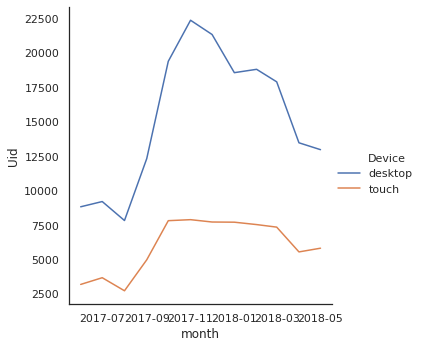

In [479]:
#Посмотрим различия по устройствам и изменение во времени
sns.relplot(data = visits.groupby(['Device', 'month'])['Uid'].nunique().reset_index(), 
            x="month", y="Uid", hue = 'Device', kind="line")

Пользователей с десктопа примерно в 2.5 раз больше, чем с мобильных устройтсв.  
С сентября 2017 количество пользователей стало увеличиваться. Пика достигло в декабре. К маю 2018 снова упало. 
Скорее всего, это связанно с сезонностью (отпуска, праздники, завершение театрального сезона на лето и пр.)
Показатели посещаемости с ПК меняются более резко, чем с мобильных устройств. Возможно, на них запускаются отдльные рекламные кампании, которые влияют на изменения посещаемости.


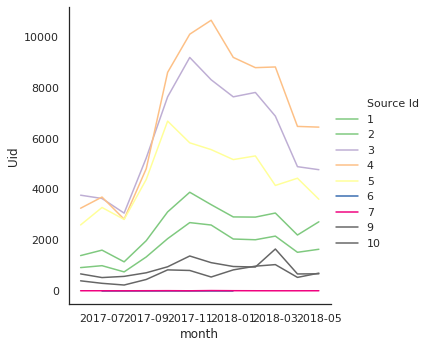

In [480]:
#Посмотрим различия по рекламным источникам и изменение во времени
sns.relplot(data = visits.groupby(['Source Id', 'month'])['Uid'].nunique().reset_index(), 
            x="month", y="Uid", hue = 'Source Id', kind="line", legend = 'full', palette = "Accent")

Из источников 3,4,5 приходит больше всего новых пользователей. Из 6, 7 - меньше всего. Именно источники 3, 4, 5 дали резкий прирост осенью 2017. 

### *Шаг 2.1.2 Сколько сессий в день?*

Сессий в день: 889.0274725274726


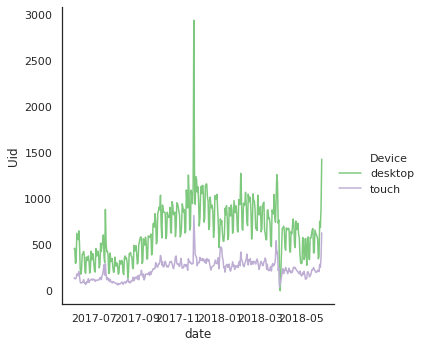

In [481]:
print('Сессий в день:', visits.groupby('date')['Uid'].count().mean())
sns.relplot(data = visits.groupby(['Device', 'date'])['Uid'].count().reset_index(), 
            x="date", y="Uid", hue = 'Device', kind="line", legend = 'full', palette = "Accent")

Только 8% пользователей совершают больше одной сессии в день, поэтому количество сессий мало отличается от количества пользователей: распределение по девайсам такое же (с десктопов в 2.5 раза больше, чем с мобильных устройств)

### *Шаг 2.1.3 Сколько длится одна сессия?*

In [482]:
#Рассчитаем медианную продолжительность, чтобы исключить выбросы
visits['duration'].median()

6.0

In [483]:
#По девайсам
visits.groupby(['Device'])['duration'].median().reset_index()

,Device,duration
0,desktop,7.0
1,touch,4.0


In [484]:
#По источникам
visits.groupby(['Source Id'])['duration'].median().sort_values(ascending = False).reset_index()

,Source Id,duration
0,1,11.0
1,6,8.0
2,2,8.0
3,10,6.0
4,9,5.0
5,5,5.0
6,4,5.0
7,3,5.0
8,7,3.0


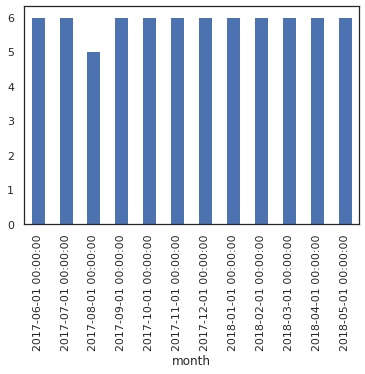

In [485]:
#Как продолжительность сессии менялась со временем
visits.groupby('month')['duration'].median().plot(x = 'month', y = 'duration', kind = 'bar')

С ПК пользователи проводят на сайте на 75% больше времени, чем с мобильных устройств. Видимо, пользоваться с ПК - удобнее.  
Медианное время сессии различается в зависимости от источников: С источника 1 пользователи проводят на сайте 11 минут. С самых популярных источников (3,4,5) - 5 минут.  
Со временем медианная продолжиельность сессий не меняется.

### *Шаг 2.1.4 Как часто люди возвращаются?*

In [486]:
#Найдем месяц первой сессии
cohort = visits.groupby('Uid')['month'].min()
cohort.name = 'cohort'
visits = visits.join(cohort, on='Uid')

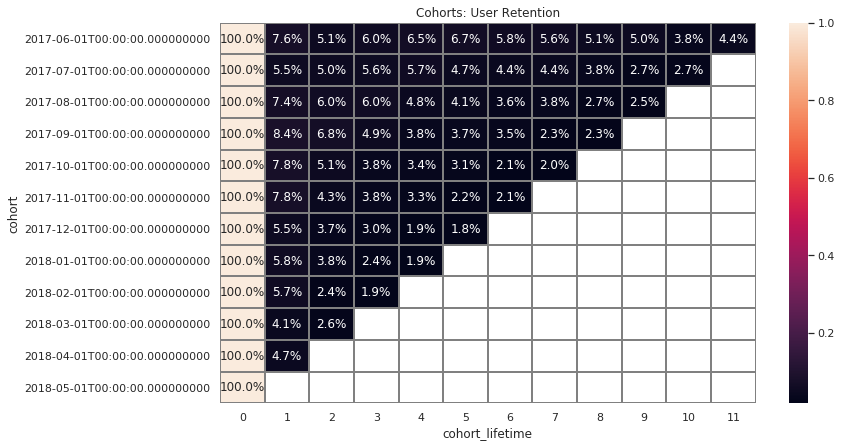

In [487]:
#Добавим lifetime
visits['cohort_lifetime'] = visits['month'] - visits['cohort']
visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype(int)

#Сгруппируем по когортам
cohorts = visits.groupby(['cohort', 'cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()

#Добавим изначальное количество юзеров в когорте
users_in_cohort = cohorts[cohorts['cohort_lifetime'] == 0][['cohort', 'Uid']]
users_in_cohort = users_in_cohort.rename(columns = {'Uid':'cohort_users'})
cohorts = cohorts.merge(users_in_cohort, on = 'cohort')

#Рассчитаем retention rate
cohorts['retention_rate'] = cohorts['Uid'] / cohorts['cohort_users']

#Построим сводную таблицу и визуализируем изменения показателя во времени на тепловой карте
retention_pivot = cohorts.pivot_table(index='cohort',
                                      columns='cohort_lifetime',
                                      values='retention_rate',
                                      aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(12, 7))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

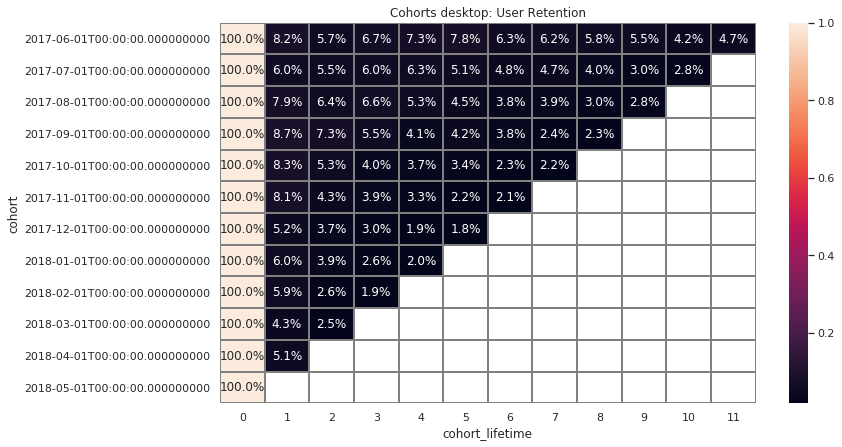

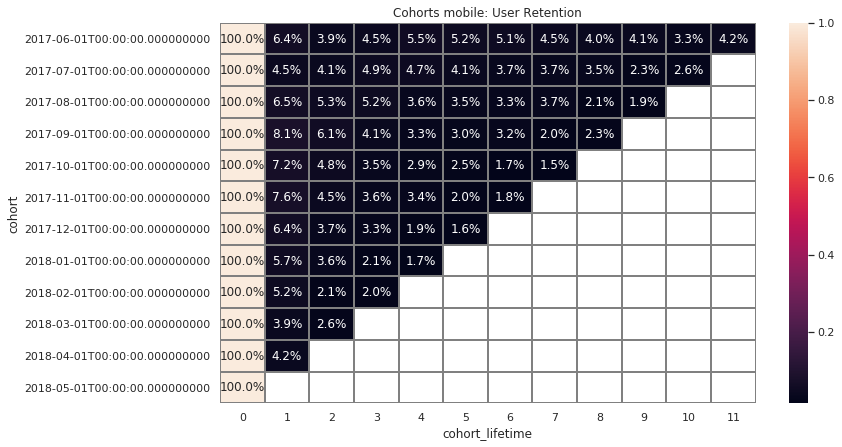

In [488]:
#Сделаем срез по ПК
visits_d = visits.query('Device == "desktop"')

#Найдем месяц первой сессии
cohort_d = visits_d.groupby('Uid')['month'].min()
cohort_d.name = 'cohort_d'
visits_d = visits_d.join(cohort_d, on='Uid')

#Добавим lifetime
visits_d['cohort_lifetime'] = visits_d['month'] - visits_d['cohort']
visits_d['cohort_lifetime'] = (visits_d['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype(int)

#Сгруппируем по когортам
cohorts_d = visits_d.groupby(['cohort', 'cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()

#Добавим изначальное количество юзеров в когорте
users_in_cohort_d = cohorts_d[cohorts_d['cohort_lifetime'] == 0][['cohort', 'Uid']]
users_in_cohort_d = users_in_cohort_d.rename(columns = {'Uid':'cohort_users'})
cohorts_d = cohorts_d.merge(users_in_cohort_d, on = 'cohort')

#Рассчитаем retention rate
cohorts_d['retention_rate'] = cohorts_d['Uid'] / cohorts_d['cohort_users']

#Построим сводную таблицу и визуализируем изменения показателя во времени на тепловой карте
retention_pivot_d = cohorts_d.pivot_table(index='cohort',
                                      columns='cohort_lifetime',
                                      values='retention_rate',
                                      aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(12, 7))
plt.title('Cohorts desktop: User Retention')
sns.heatmap(retention_pivot_d, annot=True, fmt='.1%', linewidths=1, linecolor='gray');


#Сделаем срез по мобильным устройствам
visits_m = visits.query('Device == "touch"')

#Найдем месяц первой сессии
cohort_m = visits_m.groupby('Uid')['month'].min()
cohort_m.name = 'cohort_m'
visits_m = visits_m.join(cohort_m, on='Uid')

#Добавим lifetime
visits_m['cohort_lifetime'] = visits_m['month'] - visits_m['cohort']
visits_m['cohort_lifetime'] = (visits_m['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype(int)

#Сгруппируем по когортам
cohorts_m = visits_m.groupby(['cohort', 'cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()

#Добавим изначальное количество юзеров в когорте
users_in_cohort_m = cohorts_m[cohorts_m['cohort_lifetime'] == 0][['cohort', 'Uid']]
users_in_cohort_m = users_in_cohort_m.rename(columns = {'Uid':'cohort_users'})
cohorts_m = cohorts_m.merge(users_in_cohort_m, on = 'cohort')

#Рассчитаем retention rate
cohorts_m['retention_rate'] = cohorts_m['Uid'] / cohorts_m['cohort_users']

#Построим сводную таблицу и визуализируем изменения показателя во времени на тепловой карте
retention_pivot_m = cohorts_m.pivot_table(index='cohort',
                                      columns='cohort_lifetime',
                                      values='retention_rate',
                                      aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(12, 7))
plt.title('Cohorts mobile: User Retention')
sns.heatmap(retention_pivot_m, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Если смотреть на ситуацию в целом, то во второй месяц возвращается менее 10% клиентов. Далее их число продолжает уменьшаться, но уже не так резко (не более, чем на 2%).  
Начиная с декабрьской когорты, retention rate падает. А когорта июня 2017 до сих пор самая лояльная. Кажется, маркетологи больше сосредоточились на привлечении новых клиентов, чем на retention rate.  
Retention rate на десктопе в первый месяц выше, чем на мобильных устройствах. Однако чем лайфтайм когорты, тем ближе показатели на разных девайсах.

### *Вывод по продукту*

В среднем, в день на Яндекс.Афишу заходит около 800 человек. 21 тыс. в месяц.  
Пользователей с ПК в 2.5 раз больше, чем с мобильных устройств.  
8% пользователей имеют больше, чем одну сессию в день.  
С сентября 2017 количество пользователей выросло сначала в 2, потом в 3 раза, достигнув пика в декабре 2017, потом снова пошло на спад. Для того, чтобы понять, сезонность ли это, нужны данные за большее количество полных лет. 
Больше всего пользователей приходит из источников 3, 4, 5.  
Средняя продолжительность сессии - 6 мин. Она не меняется со временем.  
С ПК сессия дольше на 75% (7 мин. против 4 мин.)  
Менее 10% пользователей повзвращаются после первого месяца. С декабря 2017 retention rate по когортам падает. Когорта июня 2017 самая лояльная.  

### *Шаг 2.2.1 Когда люди начинают покупать?*

0    0
dtype: int64


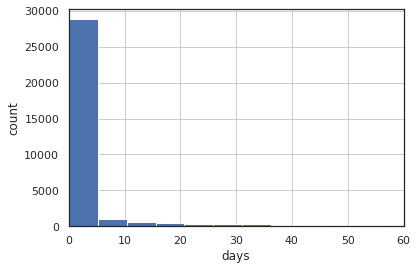

In [489]:
#Найдем день первой сессии и первой покупки
first_visit = visits.groupby('Uid')['Start Ts'].min().reset_index()
first_buy = orders.groupby('Uid')['Buy Ts'].min().reset_index()

#Объединим датафреймы
first_visit = first_visit.merge(first_buy, on = 'Uid', how = 'left')

#Удалим строки без покупок
first_visit = first_visit.dropna()

#Найдем количество дней до первой покупки
first_visit['days_to_buy'] = first_visit['Buy Ts'] - first_visit['Start Ts']
first_visit['days_to_buy'] = (first_visit['days_to_buy']/ np.timedelta64(1, 'D')).round().astype(int)

#Избавимся от строк с ошибочными данными, где покупка была раньше первого визита
first_visit = first_visit.query('days_to_buy >= 0')

first_visit['days_to_buy'].hist(bins = 70)
plt.xlim([0, 60])
plt.xlabel('days')
plt.ylabel('count')
print(first_visit['days_to_buy'].mode())

In [490]:
print(first_visit['days_to_buy'].count())
print(first_visit['days_to_buy'].value_counts())

35936
0      25380
1       1707
2        626
3        478
4        338
       ...  
309        1
341        1
313        1
345        1
247        1
Name: days_to_buy, Length: 345, dtype: int64


70% всех покупающих совершают первую покупку в день первой сессии.

Ввиду такого преобладающего значения считаем бессмысленным проверять показатель в разбивке по девайсам или источникам. Результат очевиден и будет повторять общую картину.

### *Шаг 2.2.2 Сколько раз покупают за период?*

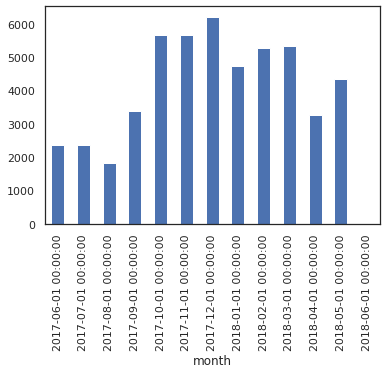

In [491]:
#Добавим столбец с месяцем покупки
orders['month'] = orders['Buy Ts'].astype('datetime64[M]')
#Посмотрим, как менялось общее количество покупок по месяцам
orders.groupby('month')['Buy Ts'].count().plot(x = 'month', y = 'Buy Ts', kind = 'bar')

C сентября 2017 покупки выросли почти в 2 раза и продолжили расти до декабря 2017 до 4000 покупок в месяц. С января 2018 кличество покупок упало до 3500 покупок с существенным провалом до 2500 покупок в апреле 2018. 

In [492]:
#Посмотрим на продажи по когортам
#Найдем месяц первой покупки
cohort_orders = orders.groupby('Uid')['month'].min()
cohort_orders.name = 'cohort_orders'
orders = orders.join(cohort_orders, on='Uid')

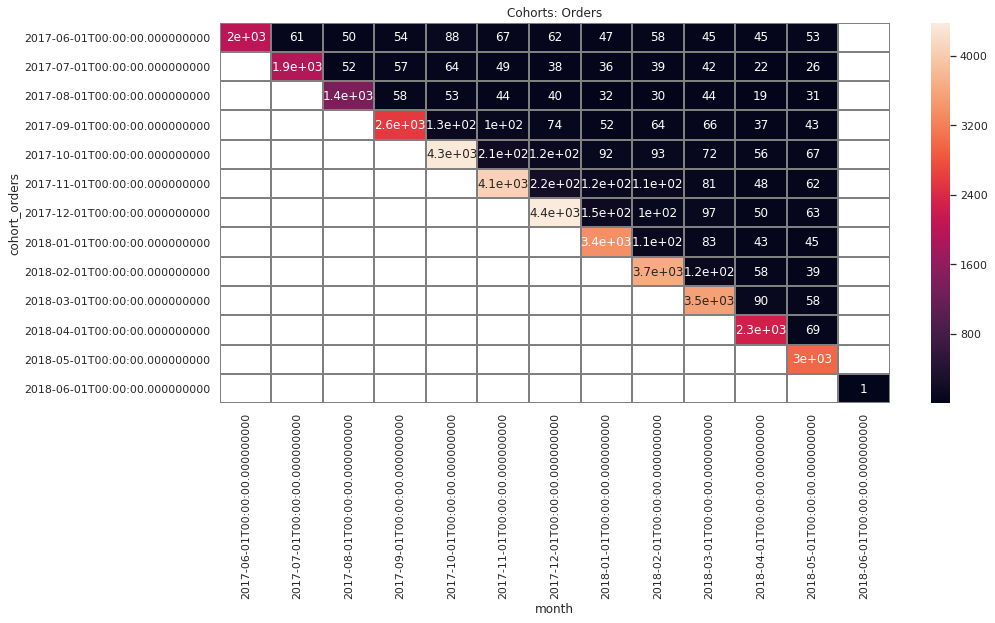

In [493]:
#Построим сводную по когортам и визуализиуем изменения на тепловой карте
orders_pivot = orders.pivot_table(index='cohort_orders', columns='month', values='Uid', aggfunc='nunique')

sns.set(style='white')
plt.figure(figsize=(15, 7))
plt.title('Cohorts: Orders')
sns.heatmap(orders_pivot, annot=True, linewidths=1, linecolor='gray');

Если смотеть в целом, то пользователи когорт с сентября 2017 начинают покупать больше (но мы помним,  что там и количество пользователей выше). с января 2018 начался спад.  
На второй месяц жизни количество покупок сокращается более чем на 90%, но в дальнейшем уменьшается уже незначительно.

In [494]:
#Посмотрим, как распеределяются покупки по девайсам и источникам
#Для этого нужно объединить таблицы orders и visits
#Сначала посмотрим, сколько Uid совпадают из обеих таблиц
orders['Uid'].isin(visits['Uid']).value_counts()

True     49941
False      474
Name: Uid, dtype: int64

Видим, что у 10% покупок сессии не зарегистрированы. Следовательно, определить их девайсы и источники мы не сможем.

In [495]:
#Добавим к таблице данные по девайсам и источникам
orders = orders.merge(visits.loc[:,['Device', 'Source Id', 'Start Ts', 'End Ts', 'Uid']], on = 'Uid', how = 'left')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722348 entries, 0 to 722347
Data columns (total 9 columns):
Buy Ts           722348 non-null datetime64[ns]
Revenue          722348 non-null float64
Uid              722348 non-null uint64
month            722348 non-null datetime64[ns]
cohort_orders    722348 non-null datetime64[ns]
Device           721874 non-null object
Source Id        721874 non-null float64
Start Ts         721874 non-null datetime64[ns]
End Ts           721874 non-null datetime64[ns]
dtypes: datetime64[ns](5), float64(2), object(1), uint64(1)
memory usage: 55.1+ MB


In [496]:
#Данные задублились, т.к. один пользователь мог совершить сессий больше, чем покупок.
#Возьмем только те сессии, где покупка попадает в интервал начала и конца
orders = orders.loc[(orders['Buy Ts'] >= orders['Start Ts']) & (orders['Buy Ts'] <= orders['End Ts'])]
orders

,Buy Ts,Revenue,Uid,month,cohort_orders,Device,Source Id,Start Ts,End Ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,desktop,1.0,2017-06-01 00:09:00,2017-06-01 00:11:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,desktop,2.0,2017-06-01 00:14:00,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,desktop,2.0,2017-06-01 00:25:00,2017-06-01 00:34:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,desktop,2.0,2017-06-01 00:14:00,2017-06-01 00:33:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,desktop,3.0,2017-06-01 07:31:00,2017-06-01 07:59:00
...,...,...,...,...,...,...,...,...,...
722332,2018-05-31 23:42:00,0.92,15854392578508828030,2018-05-01,2018-05-01,touch,4.0,2018-05-31 23:26:00,2018-05-31 23:47:00
722339,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-01,desktop,4.0,2018-05-31 23:46:00,2018-06-01 00:13:00
722341,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-01,desktop,10.0,2018-05-31 23:05:00,2018-05-31 23:55:00
722342,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-01,desktop,3.0,2018-05-31 23:52:00,2018-05-31 23:55:00


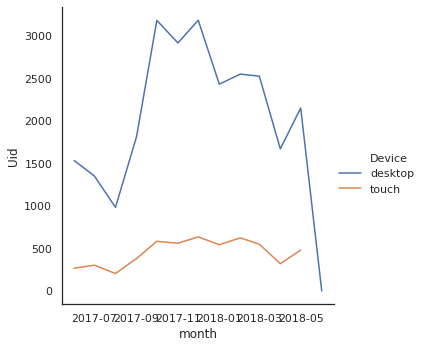

In [497]:
#Посмотрим, как распределяются покупки по девайсам
sns.relplot(data = orders.groupby(['Device', 'month'])['Uid'].nunique().reset_index(), 
            x="month", y="Uid", hue = 'Device', kind="line")

До сентября 2017 с мобильных устройств покупали в 3 раза меньше, чем с ПК. С сентября разница стала доходить до 5 раз (600 покупок против 3000 покупок в месяц). Резкий январский спад на ПК не отразился на покупках с мобильных устройств (возможно, здесь сыграла все-таки не сезонность, а возможные маркетинговые капании, которые были направлены на пользователей ПК). Апрельский спад повторился ка кна десктопе, так и на мобилках.

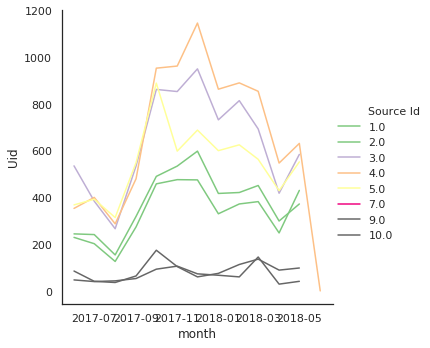

In [498]:
#Посмотрим, как изменяются покупки по источникам
sns.relplot(data = orders.groupby(['Source Id', 'month'])['Uid'].nunique().reset_index(), 
            x="month", y="Uid", hue = 'Source Id', kind="line", legend = 'full', palette = "Accent")

С сентября 2017 видим рост продаж на источниках 1, 2, 3, 4, 5. В ноябре продажи с источника 5 упали на 30%, на другиз источниках продолжили расти. Больше всего продаж с источника 4. 

### *Шаг 2.2.3 Какой средний чек?*

In [499]:
print('Средний чек:', orders['Revenue'].mean())

Средний чек: 4.649075343431779


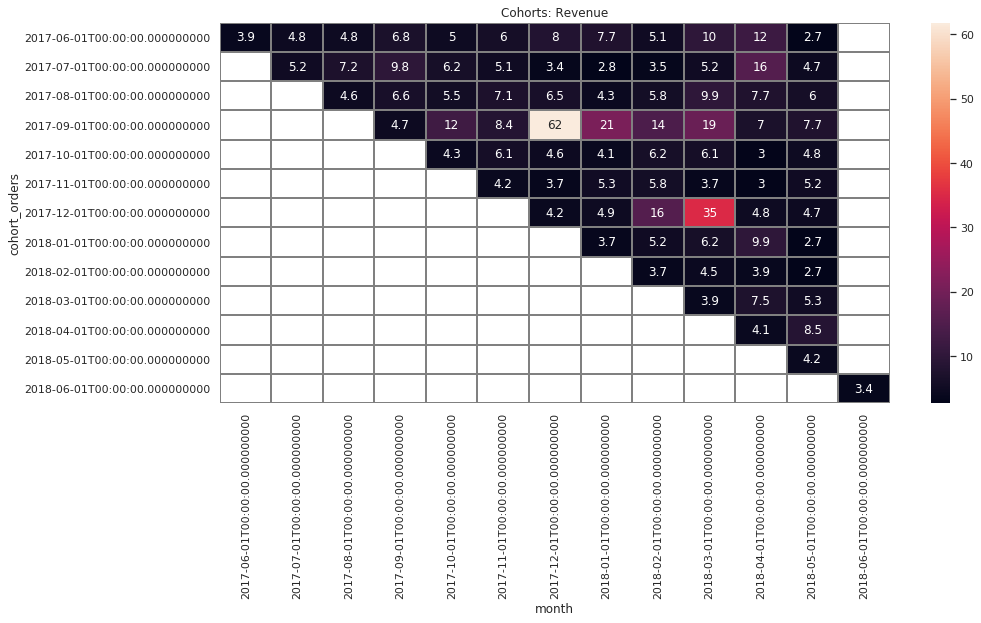

In [500]:
#Построим сводную по когортам и визуализиуем изменения на тепловой карте
revenue_pivot = orders.pivot_table(index='cohort_orders', columns='month', values='Revenue', aggfunc='mean')

sns.set(style='white')
plt.figure(figsize=(15, 7))
plt.title('Cohorts: Revenue')
sns.heatmap(revenue_pivot, annot=True, linewidths=1, linecolor='gray');

Есть тенденция на рост среднего чека с ростом лайфтайма.  
В мае 2018 в каждой когорте средний чек очень низкий.  
У когорты сентября 2017 самый высокий средний чек.  
Средний чек когорт существенно не меняется со временем (т.е. средний чек новых когорт не отличается от среднего чека старых).  

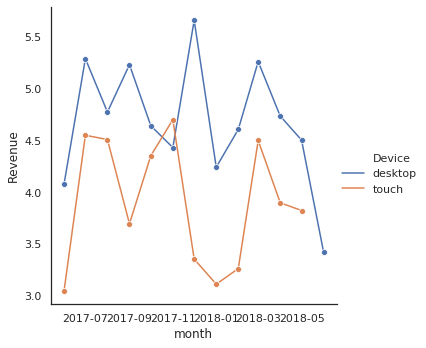

In [501]:
#Посмотрим, на иземение среднего чека по девайсам
sns.relplot(data = orders.groupby(['Device', 'month'])['Revenue'].mean().reset_index(), 
            x="month", y="Revenue", hue = 'Device', kind="line", marker = 'o')

В целом, средний чек на десктопе выше, кроме ноября 2017. Зависимости между изменениями среднего чека на разных девайсах нет (т.е. если рост на десктопе, не значит, что рост будет и на мобильных устройствах, и наоборот).  
Тенденции на рост или падение нет.

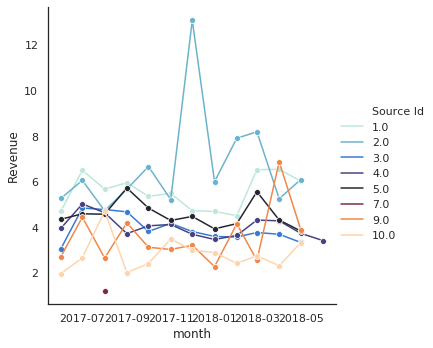

In [502]:
#Посмотрим, как изменяктся средний чек по источникам
sns.relplot(data = orders.groupby(['Source Id', 'month'])['Revenue'].mean().reset_index(), 
            x="month", y="Revenue", hue = 'Source Id', kind="line", legend = 'full', palette = "icefire", marker = 'o')

С октября 2017 самый высокий средний чек на источнике 2. На источниках 1, 9 наблюдается тенденция к росту среднего чека, на источнике 3 - падение. Источники 4, 5, 10 - стабильны. 

### *Шаг 2.2.4 Сколько денег приносят (LTV)?*

In [503]:
#Рассчитаем текущий ltv каждой когорты
orders_ltv = orders.groupby('cohort_orders').agg({'Revenue':'sum', 'Uid':'nunique'})
orders_ltv['ltv'] = orders_ltv['Revenue'] / orders_ltv['Uid']
orders_ltv = orders_ltv.reset_index()
orders_ltv

,cohort_orders,Revenue,Uid,ltv
0,2017-06-01,14003.38,1820,7.694165
1,2017-07-01,11183.40,1646,6.794289
2,2017-08-01,7541.75,1151,6.552346
3,2017-09-01,19661.50,2151,9.140632
4,2017-10-01,19170.86,3627,5.285597
5,2017-11-01,17260.67,3279,5.264004
6,2017-12-01,21334.61,3512,6.074775
7,2018-01-01,11978.62,2716,4.410390
8,2018-02-01,11690.29,2862,4.084658
9,2018-03-01,12622.44,2738,4.610095


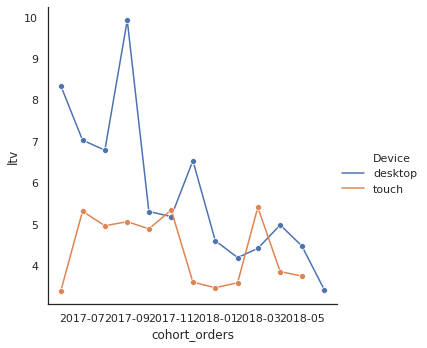

In [504]:
#По девайсам
orders_ltv_device = orders.groupby(['Device', 'cohort_orders']).agg({'Revenue':'sum', 'Uid':'nunique'})
orders_ltv_device['ltv'] = orders_ltv_device['Revenue'] / orders_ltv_device['Uid']
orders_ltv_device = orders_ltv_device.reset_index()
sns.relplot(data = orders_ltv_device, 
            x='cohort_orders', y='ltv', hue = 'Device', kind='line', marker = 'o')

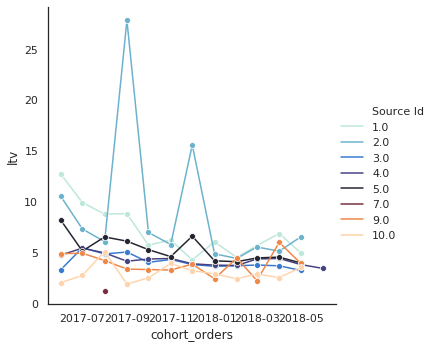

In [505]:
#По источникам
orders_ltv_source = orders.groupby(['Source Id', 'cohort_orders']).agg({'Revenue':'sum', 'Uid':'nunique'})
orders_ltv_source['ltv'] = orders_ltv_source['Revenue'] / orders_ltv_source['Uid']
orders_ltv_source = orders_ltv_source.reset_index()
sns.relplot(data = orders_ltv_source, 
            x='cohort_orders', y='ltv', hue = 'Source Id', 
            kind='line', marker = 'o', palette = 'icefire', legend = 'full' )

Судя по самой первой когорте, за год один пользователь приносит 7.7 (рублей?).  
Общий LTV  по когортам растет, учитывая, что показатель у некоторых более поздних когорт выше или такой же, как и у более старых, при том, что от данных пользователей ожидается еще доход в будущем. 
lTV с десктоп выше, чем с мобильных устройств, за исключением ноябрьской и мартовской когорты.  
lTV по источникам примерно одинаковый. Но у декабрьской когорты есть всплеск по 3 и 5 источникам, и у сентябрьской когорты по 3 источнику. 

### *Вывод по продажам*

70% пользователей совершают покупку в день первой сессии.  
C сентября 2017 покупки выросли почти в 2 раза и продолжили расти до декабря 2017 до 4000 покупок в месяц. С января 2018 количество покупок упало до 3500 покупок с существенным провалом до 2500 покупок в апреле 2018.  
На второй месяц жизни когорты, количество ее покупок сокращается на 90% и продолжает падать, но уже незначительно. С мобильных покупки совершаются в 3-5 раз реже, чем с десктопов. Больше всего продаж с источников 3, 4.  
Средний чек за весь период - 4,65. Есть тенденция на рост среднего чека с ростом лайфтайма. По когортам средний чек не растет. С октября 2017 самый высокий средний чек на источнике 2. На источниках 1, 9 наблюдается тенденция к росту среднего чека, на источнике 3 - падение. Источники 4, 5, 10 - стабильны.  
За год один пользователь приносит 7.7 у.е. LTV по когортам растет. LTV с десктоп выше, чем с мобильных устройств, за исключением ноябрьской и мартовской когорты. LTV по источникам примерно одинаковый.

### *Шаг 2.3.1: Сколько денег потратили? Всего / на каждый источник / по времени*

In [506]:
print('На маркетинг потратили за год:', costs['costs'].sum())
print('На маркетинг потратили в среднем за месяц:', costs['costs'].sum() / 12)

На маркетинг потратили за год: 329131.62
На маркетинг потратили в среднем за месяц: 27427.635


source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64


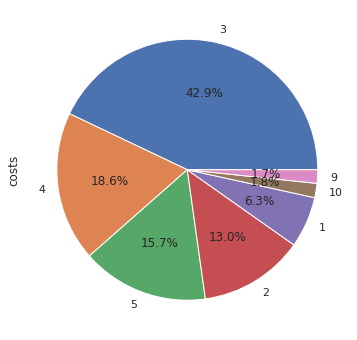

In [507]:
#По источникам
print(costs.groupby('source_id')['costs'].sum().sort_values(ascending = False))
costs.groupby('source_id')['costs'].sum().sort_values(ascending = False).plot(kind = 'pie', 
                                                                              autopct='%1.1f%%', figsize = (10,6))

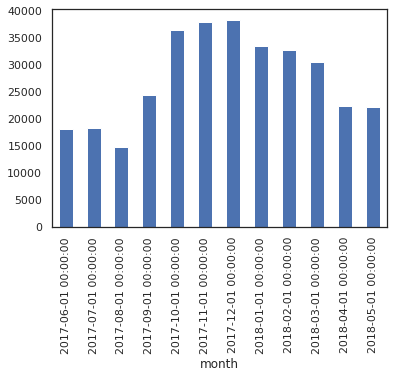

In [508]:
#По времени

#Добавим столбец с месяцами
costs['month'] = costs['dt'].astype('datetime64[M]')

costs.groupby('month')['costs'].sum().plot(x = 'month', y = 'costs', kind = 'bar')

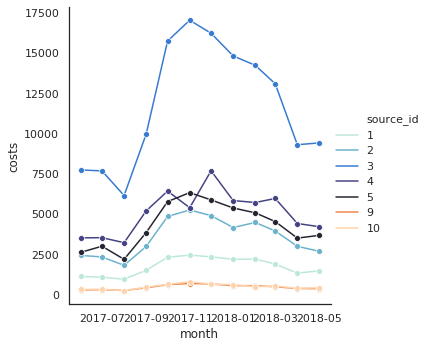

In [509]:
#По источникам по времени
sns.relplot(data = costs.groupby(['source_id', 'month'])['costs'].sum().reset_index(), 
            x='month', y='costs', hue = 'source_id', 
            kind='line', marker = 'o', palette = 'icefire', legend = 'full' )

За год на маркетинг потратили 330 тыс.  43% из них на источник 3, еще 59% на источники 4, 5, 2.  
С сентября 2017 расходы на марктинг начали расти. по отношению к июню-июлю выросли в 2 раза (с 17 до 35 тыс. в мес.) С февраля 2018 начали снижаться и к маю 2018 составили около 22 тыс.в мес.)  
Самый большой рост расходов был на источник 3 (с 7500 до 17500), источники 2, 4, 5 выросли с сентября примерно в 2 раза.

### *Шаг 2.3.2: Сколько стоило привлечение одного покупателя из каждого источника?*

Так как мы выяснили, что 70% пользователей делают покупку в первый день сессии, можем считать, что в течение первого месяца покупку делает большинство. Поэтому будем полагать, что клиент сделал первую покупку в тот же месяц, когда и были потрачены деньги на его привлечение. 

In [510]:
#Сгруппируем данные в costs
costs_cohort = costs.groupby(['source_id', 'month'])['costs'].sum().reset_index()
costs_cohort

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75
...,...,...,...
79,10,2018-01-01,614.35
80,10,2018-02-01,480.88
81,10,2018-03-01,526.41
82,10,2018-04-01,388.25


In [511]:
#Объединим таблицы orders_ltv_source и costs_cohort
orders_ltv_source['Source Id'] = orders_ltv_source['Source Id'].astype(int)
orders_ltv_source = orders_ltv_source.merge(costs_cohort, left_on = ['cohort_orders', 'Source Id'], right_on = ['month', 'source_id'])
orders_ltv_source

,Source Id,cohort_orders,Revenue,Uid,ltv,source_id,month,costs
0,1,2017-06-01,3582.44,282,12.703688,1,2017-06-01,1125.61
1,1,2017-07-01,2565.62,259,9.905869,1,2017-07-01,1072.88
2,1,2017-08-01,1403.10,160,8.769375,1,2017-08-01,951.81
3,1,2017-09-01,2969.73,337,8.812255,1,2017-09-01,1502.01
4,1,2017-10-01,2804.16,491,5.711120,1,2017-10-01,2315.75
...,...,...,...,...,...,...,...,...
79,10,2018-01-01,225.35,78,2.889103,10,2018-01-01,614.35
80,10,2018-02-01,260.69,109,2.391651,10,2018-02-01,480.88
81,10,2018-03-01,378.06,131,2.885954,10,2018-03-01,526.41
82,10,2018-04-01,216.50,86,2.517442,10,2018-04-01,388.25


In [512]:
#Удалим повторяющиеся столбцы
orders_ltv_source = orders_ltv_source.drop(['month', 'source_id'], axis='columns')
orders_ltv_source

,Source Id,cohort_orders,Revenue,Uid,ltv,costs
0,1,2017-06-01,3582.44,282,12.703688,1125.61
1,1,2017-07-01,2565.62,259,9.905869,1072.88
2,1,2017-08-01,1403.10,160,8.769375,951.81
3,1,2017-09-01,2969.73,337,8.812255,1502.01
4,1,2017-10-01,2804.16,491,5.711120,2315.75
...,...,...,...,...,...,...
79,10,2018-01-01,225.35,78,2.889103,614.35
80,10,2018-02-01,260.69,109,2.391651,480.88
81,10,2018-03-01,378.06,131,2.885954,526.41
82,10,2018-04-01,216.50,86,2.517442,388.25


In [513]:
#Рассчитаем стоимость привлечения покупателя
orders_ltv_source['cac'] = orders_ltv_source['costs'] / orders_ltv_source['Uid']
#Посмотрим  по источникам
orders_ltv_source.groupby('Source Id')['cac'].mean().sort_values(ascending = False)

Source Id
3     19.048414
2     11.983890
9      9.033251
5      8.133794
4      7.948091
10     5.886022
1      4.927088
Name: cac, dtype: float64

Дороже всего привлечение одного покупателя стоит на источнике 3 (19), дешевле всего на источнике 1 (4.9)

### *Шаг 2.3.3: На сколько окупились расходы? (ROI)?*

In [514]:
#Подготовим данные
orders['Source Id'] = orders['Source Id'].astype(int)
costs_cohort = costs_cohort.rename(columns = {'source_id':'Source Id', 'month':'cohort_orders'})

In [515]:
#Создадим таблицу
ROI = orders.groupby(['Source Id', 'cohort_orders', 'month']).agg({'Uid':'nunique', 'Revenue':'sum'}).reset_index()
ROI

,Source Id,cohort_orders,month,Uid,Revenue
0,1,2017-06-01,2017-06-01,245,1222.78
1,1,2017-06-01,2017-07-01,6,36.20
2,1,2017-06-01,2017-08-01,13,88.09
3,1,2017-06-01,2017-09-01,10,97.37
4,1,2017-06-01,2017-10-01,20,203.05
...,...,...,...,...,...
490,10,2018-03-01,2018-03-01,130,371.71
491,10,2018-03-01,2018-04-01,2,6.35
492,10,2018-04-01,2018-04-01,84,204.77
493,10,2018-04-01,2018-05-01,2,11.73


In [516]:
#Объединим таблицы
ROI = ROI.merge(costs_cohort, on = ['Source Id', 'cohort_orders'])
ROI

,Source Id,cohort_orders,month,Uid,Revenue,costs
0,1,2017-06-01,2017-06-01,245,1222.78,1125.61
1,1,2017-06-01,2017-07-01,6,36.20,1125.61
2,1,2017-06-01,2017-08-01,13,88.09,1125.61
3,1,2017-06-01,2017-09-01,10,97.37,1125.61
4,1,2017-06-01,2017-10-01,20,203.05,1125.61
...,...,...,...,...,...,...
488,10,2018-03-01,2018-03-01,130,371.71,526.41
489,10,2018-03-01,2018-04-01,2,6.35,526.41
490,10,2018-04-01,2018-04-01,84,204.77,388.25
491,10,2018-04-01,2018-05-01,2,11.73,388.25


In [517]:
#Добавим столбец с общим количеством людей в когорте
uids_in_cohort = ROI.groupby(['Source Id', 'cohort_orders'])['Uid'].sum().reset_index()
uids_in_cohort = uids_in_cohort.rename(columns = {'Uid':'uids_in_cohort'})
ROI = ROI.merge(uids_in_cohort, on = ['Source Id', 'cohort_orders'])
ROI

,Source Id,cohort_orders,month,Uid,Revenue,costs,uids_in_cohort
0,1,2017-06-01,2017-06-01,245,1222.78,1125.61,385
1,1,2017-06-01,2017-07-01,6,36.20,1125.61,385
2,1,2017-06-01,2017-08-01,13,88.09,1125.61,385
3,1,2017-06-01,2017-09-01,10,97.37,1125.61,385
4,1,2017-06-01,2017-10-01,20,203.05,1125.61,385
...,...,...,...,...,...,...,...
488,10,2018-03-01,2018-03-01,130,371.71,526.41,132
489,10,2018-03-01,2018-04-01,2,6.35,526.41,132
490,10,2018-04-01,2018-04-01,84,204.77,388.25,86
491,10,2018-04-01,2018-05-01,2,11.73,388.25,86


In [523]:
#Добавим ltv и cac
ROI['ltv'] = ROI['Revenue'] / ROI['uids_in_cohort']
ROI['cac'] = ROI['costs'] / ROI['uids_in_cohort']
ROI['roi'] = ROI['ltv'] / ROI['cac']
#Добавим lifetime
ROI['cohort_lifetime'] = ROI['month'] - ROI['cohort_orders']
ROI['cohort_lifetime'] = (ROI['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype(int)
ROI

,source_id,cohort_orders,month,Uid,Revenue,costs,uids_in_cohort,ltv,cac,roi,cohort_lifetime
0,1,2017-06-01,2017-06-01,245,1222.78,1125.61,385,3.176052,2.923662,1.086327,0
1,1,2017-06-01,2017-07-01,6,36.20,1125.61,385,0.094026,2.923662,0.032160,1
2,1,2017-06-01,2017-08-01,13,88.09,1125.61,385,0.228805,2.923662,0.078260,2
3,1,2017-06-01,2017-09-01,10,97.37,1125.61,385,0.252909,2.923662,0.086504,3
4,1,2017-06-01,2017-10-01,20,203.05,1125.61,385,0.527403,2.923662,0.180391,4
...,...,...,...,...,...,...,...,...,...,...,...
488,10,2018-03-01,2018-03-01,130,371.71,526.41,132,2.815985,3.987955,0.706123,0
489,10,2018-03-01,2018-04-01,2,6.35,526.41,132,0.048106,3.987955,0.012063,1
490,10,2018-04-01,2018-04-01,84,204.77,388.25,86,2.381047,4.514535,0.527418,0
491,10,2018-04-01,2018-05-01,2,11.73,388.25,86,0.136395,4.514535,0.030212,1


Таблица готова. Можем посмотреть окупаемость по источникам. Возьмем только источники 1, 2, 3, 4, 5, т.к. по другим практически не было расходов на привлечение.

In [524]:
#Посмотрим окупаемость по первому источнику
ROI = ROI.rename(columns = {'Source Id':'source_id'})

ROI_1 = ROI.query('source_id == 1')

output_1 = ROI_1.pivot_table(
        index='cohort_orders', 
        columns='cohort_lifetime', 
        values='roi', 
        aggfunc='mean')

output_1.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
cohort_orders,,,,,,,,,,,,
2017-06-01,1.09,1.12,1.20,1.28,1.46,1.69,2.22,2.31,2.46,2.88,3.14,3.18
2017-07-01,1.54,1.62,1.98,2.05,2.11,2.13,2.14,2.14,2.19,2.33,2.39,NaN
2017-08-01,0.85,0.96,0.98,1.05,1.09,1.13,1.17,1.32,1.45,1.47,NaN,NaN
2017-09-01,1.04,1.21,1.35,1.47,1.64,1.69,1.91,1.93,1.98,NaN,NaN,NaN
2017-10-01,1.01,1.08,1.11,1.12,1.15,1.19,1.20,1.21,NaN,NaN,NaN,NaN
2017-11-01,1.05,1.15,1.19,1.24,1.26,1.26,1.32,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.86,0.89,0.93,0.96,0.98,0.99,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.74,0.84,0.94,1.02,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.66,0.74,0.75,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [526]:
output_1.cumsum(axis=1).mean(axis=0)

cohort_lifetime
0     0.977239
1     1.091915
2     1.156034
3     1.215338
4     1.339875
5     1.438998
6     1.660081
7     1.780328
8     2.019497
9     2.225562
10    2.767893
11    3.182665
dtype: float64

 В целом затраты по первому источнику окупаются на второй месяц. За год, судя по первой когорте, ожидается ROI 300% с клиента. Когорты января, декабря, февраля 2018 окупаются хуже остальных. Февральская когорта "отбила" только 75% затрат. Вообще начиная с декабрьской, когорты стали окупаться хуже.

In [527]:
#Посмотрим окупаемость по второму источнику
ROI_2 = ROI.query('source_id == 2')

output_2 = ROI_2.pivot_table(
        index='cohort_orders', 
        columns='cohort_lifetime', 
        values='roi', 
        aggfunc='mean')

output_2.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
cohort_orders,,,,,,,,,,,,
2017-06-01,0.54,0.59,0.64,0.73,0.80,0.84,0.94,1.08,1.13,1.17,1.19,1.2
2017-07-01,0.54,0.55,0.59,0.64,0.65,0.66,0.66,0.66,0.66,0.66,0.67,NaN
2017-08-01,0.28,0.33,0.36,0.36,0.37,0.37,0.38,0.39,0.39,0.43,NaN,NaN
2017-09-01,0.45,0.76,0.83,2.23,2.37,2.55,2.66,2.69,2.71,NaN,NaN,NaN
2017-10-01,0.46,0.54,0.58,0.59,0.60,0.62,0.62,0.64,NaN,NaN,NaN,NaN
2017-11-01,0.38,0.41,0.45,0.47,0.48,0.48,0.49,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.60,0.69,0.96,1.28,1.29,1.30,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.25,0.28,0.31,0.32,0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.27,0.28,0.29,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [528]:
output_2.cumsum(axis=1).mean(axis=0)

cohort_lifetime
0     0.440524
1     0.470147
2     0.544352
3     0.767716
4     0.862351
5     0.974412
6     0.955225
7     1.092407
8     1.223056
9     0.755932
10    0.932818
11    1.199495
dtype: float64

Затраты по второму источнику окупаются только через год. И об этом мы не можем говорить с уверенностью, т.к. только одна когорта имеет такой лайфтайм. На данный момент, кроме первой, окупились еще только сентябрьская и  и декабрьская когрты, которые, судя по общей картине, являются,с корее, исключениями, хотя в них явно удалось привлечь хороших клиентов.

In [529]:
#Посмотрим окупаемость по третьему источнику
ROI_3 = ROI.query('source_id == 3')

output_3 = ROI_3.pivot_table(
        index='cohort_orders', 
        columns='cohort_lifetime', 
        values='roi', 
        aggfunc='mean')

output_3.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
cohort_orders,,,,,,,,,,,,
2017-06-01,0.21,0.22,0.22,NaN,0.23,0.23,0.23,0.23,0.24,0.24,0.24,0.24
2017-07-01,0.24,0.25,0.26,0.26,0.27,0.27,0.28,0.28,0.28,0.29,0.29,NaN
2017-08-01,0.20,0.20,0.21,0.21,0.22,0.22,0.22,0.22,0.22,0.22,NaN,NaN
2017-09-01,0.25,0.25,0.26,0.26,0.26,0.27,0.28,0.28,0.28,NaN,NaN,NaN
2017-10-01,0.21,0.21,0.22,0.22,0.22,0.22,0.22,0.23,NaN,NaN,NaN,NaN
2017-11-01,0.20,0.20,0.21,0.22,0.22,0.22,0.22,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.21,0.21,0.21,0.21,0.21,0.22,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.17,0.17,0.17,0.17,0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.19,0.20,0.20,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [530]:
output_3.cumsum(axis=1).mean(axis=0)

cohort_lifetime
0     0.199460
1     0.204555
2     0.214936
3     0.219962
4     0.225056
5     0.234163
6     0.240800
7     0.246834
8     0.255242
9     0.250451
10    0.265623
11    0.243634
dtype: float64

По третьему источнику затраты на маркетинг за год окупаются только на 25%. Начиная с январской когорты, идет падение по окупаемости.

In [531]:
#Посмотрим окупаемость по четвертому источнику
ROI_4 = ROI.query('source_id == 4')

output_4 = ROI_4.pivot_table(
        index='cohort_orders', 
        columns='cohort_lifetime', 
        values='roi', 
        aggfunc='mean')

output_4.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
cohort_orders,,,,,,,,,,,,
2017-06-01,0.41,0.42,0.43,0.44,0.46,0.48,0.51,0.51,0.52,0.52,0.53,0.54
2017-07-01,0.58,0.59,0.60,0.62,0.62,0.63,0.64,0.64,0.66,0.67,NaN,NaN
2017-08-01,0.42,0.42,0.43,0.43,0.44,0.44,0.45,0.45,0.46,0.46,NaN,NaN
2017-09-01,0.34,0.35,0.36,0.37,0.37,0.38,0.38,0.38,0.39,NaN,NaN,NaN
2017-10-01,0.60,0.62,0.63,0.64,0.64,0.66,0.66,0.66,NaN,NaN,NaN,NaN
2017-11-01,0.71,0.74,0.75,0.77,0.78,0.78,0.79,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.52,0.53,0.54,0.54,0.55,0.55,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.49,0.51,0.51,0.52,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.52,0.53,0.54,0.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [532]:
output_4.cumsum(axis=1).mean(axis=0)

cohort_lifetime
0     0.511666
1     0.525741
2     0.535677
3     0.540105
4     0.547770
5     0.562175
6     0.571194
7     0.531656
8     0.505412
9     0.549823
10    0.531219
11    0.537356
dtype: float64

За год затраты по 4 источнику окупаются на 50%. Самая низкая окупаемость у сентябрьской когорты. Самая высокая - у январской.

In [533]:
#Посмотрим окупаемость по пятому источнику
ROI_5 = ROI.query('source_id == 5')

output_5 = ROI_5.pivot_table(
        index='cohort_orders', 
        columns='cohort_lifetime', 
        values='roi', 
        aggfunc='mean')

output_5.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
cohort_orders,,,,,,,,,,,,
2017-06-01,0.66,0.71,0.75,0.87,0.95,1.01,1.07,1.13,1.17,1.22,1.24,1.25
2017-07-01,0.63,0.66,NaN,0.67,0.68,0.68,0.68,0.68,0.69,0.70,0.70,NaN
2017-08-01,0.63,0.66,0.72,0.77,0.84,0.86,0.89,0.92,0.92,0.94,NaN,NaN
2017-09-01,0.82,0.84,0.85,0.86,0.86,0.88,0.88,0.89,0.90,NaN,NaN,NaN
2017-10-01,0.74,0.74,0.75,0.76,0.78,0.79,0.80,0.81,NaN,NaN,NaN,NaN
2017-11-01,0.39,0.39,0.41,0.43,0.44,0.44,0.44,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.50,0.51,0.53,0.72,0.73,0.74,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.39,0.41,0.42,0.44,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.43,0.44,0.45,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [534]:
output_5.cumsum(axis=1).mean(axis=0)

cohort_lifetime
0     0.549264
1     0.574196
2     0.595908
3     0.664234
4     0.714619
5     0.772382
6     0.793833
7     0.885973
8     0.921709
9     0.952684
10    0.968344
11    1.245899
dtype: float64

По пятому источнику затраты окупаются за год. Начиная с ноябрьской, корогты стали окупаться хуже, т.е. источник стал менее эффективным.

### *Вывод по маркетингу*

За год на маркетинг потратили 330 тыс. 43% из них на источник 3, еще 59% на источники 4, 5, 2.
С сентября 2017 расходы на марктинг начали расти, с февраля 2018 начали снижаться и к маю 2018 составили около 22 тыс.в мес.) 
Дороже всего привлечение одного покупателя стоит на источнике 3 (19), дешевле всего на источнике 1 (4.9).  
Хорошо окупаются только затраты на источник 1. Затраты на 2 и 5 источники окупаются только за год. Другие источники окупаются за год только 25%-50% затрат. На 1, 3, 5 источниках наблюдается спад окупаемости.

## Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?

Маркетингу стоит больше состредоточиться на рекламе для юзеров с ПК, т.к. количество продаж и LTV на этой платформе выше в 3-5 раз.  
Затраты на меркетинг в целом за год не окупились. Retention rate - слабая зона, т.к. возвращается менее 10% пользователей. Стоит состредоточиться на данном показателе, чтобы повысить LTV каждого клиента и, тем самым, окупаемость.  
Источник 3 изживает себя: падает средний чек и окупаемость, - а затраты на него остаются самыми высокими. Стоит пересмотреть работу с данным источником.  
Стоит вложить больше средств в источник 1: он окупается на 300% и с него наблюдаетмя рост среднего чека.